In [2]:
#To generate a report about the consistency score of combined predicted data
#It also gives regions of interest, that could be good to resegment the data
#and test again with the Machine Learning

#To generate a pdf of this report, use the command line and type
#jupyter nbconvert --no-input --execute --to pdf GenerateReportAndAutoPointsOfInterest.ipynb

# This software requires leopardgecko.py and its dependencies
# For the pdf export to work it also needs the python packages
# nbconvert and nbformat
#and a TeX distribution
#https://nbconvert.readthedocs.io/en/latest/

#This should be used in conjuction with script
#lg-genpredreport.py

import leopardgecko as lg
import os
import numpy as np
import matplotlib.pyplot as plt
import yaml

In [33]:
# Read configuration file
# generated by a script

yamlobj=None

with open('lg-genpredcsreport.yaml') as f:
    #yamlobj = yaml.load(f)
    yamlobj = yaml.load(f, Loader=yaml.FullLoader)

#f = file("GenerateReportAndAutoPointsOfInterest.yaml" , 'r')
#yamlobj = yaml.load(f)

#print(yamlobj)

# **Read Configuration Settings**

#Data weighing
dweightingmethod = yamlobj["csweightingmethod"]
#print( "dweightingmethod={}".format(dweightingmethod) )

#Average Pooling settings
w_avg = yamlobj["avgpwidth"] #Chunks for the average pooling 3D using the GPU. Should not affect final data
k_width = yamlobj["avgpkwidth"]
s_stride= yamlobj["avgpstride"]

bForceRecalculation = yamlobj["avgpforcerecalc"]
#print(type(bForceRecalculation))
# True: In case AvgPool of score data already exists, force recalculation
# False: Use existing file if it exists

data_filename = yamlobj["datafilename"]


#Optional for plotting the score of the volume that was segmented manually
mySegmentedVolumes=None
#Gets filename containing volumes
vols_filename = yamlobj["csvolscalculatefile"]
#TODO: Read volumes from the filename specified
#Assume is a text file
if not vols_filename is None:
    with open(vols_filename, "r") as filestream:
        mySegmentedVolumes=[]
        for line in filestream:
            currentline = line.split(",")
            if len(currentline)==6:
                mySegmentedVolumes.append ( (int(currentline[0]) , \
                                          int(currentline[1]) , \
                                          int(currentline[2]) , \
                                          int(currentline[3]) , \
                                          int(currentline[4]) , \
                                          int(currentline[5]) ))
#print(mySegmentedVolumes)

#Read regions-of-interes settings
csroimethod = yamlobj["csroimethod"]

#outputfilepdf = yamlobj["outputfilepdf"] #not needed by this notebook, this is used by the python code

dataoutfolder = yamlobj["dataoutfolder"]

#Sørensen–Dice coefficient calculation parameters
dosdccalculation = yamlobj["dosdccalculation"]

In [4]:
print ("Data filename : " , data_filename)
#Check if average pooling has already been done

Data filename :  /workspace/for_luis/Programming/BenchmUsingGasHydrateData/2021-03-11_predicted_volumes/2021-03-12_final_12_volumes_combined.h5


In [5]:
 #Uses constructor for class lg
predicteddata_lg = lg.PredictedData(data_filename)

In [6]:
print("Shape: " , predicteddata_lg.data_da.shape )

Shape:  (2000, 1554, 1554)


In [7]:
#Get Maximum and minimum value
print ( "Values: max = {} , min = {} ".format(predicteddata_lg.vmax, predicteddata_lg.vmin) )

Values: max = 12 , min = 0 


# Consistency score (CS)

In [8]:
print ("Weighting data to get consistency score using method" ,dweightingmethod)

Weighting data to get consistency score using method MaxMinSquare


In [9]:
cs , cs_avg = predicteddata_lg.setWeightedDataMethod(dweightingmethod)

In [10]:
print("Consistency score whole volume average = {}".format(cs_avg))

Consistency score whole volume average = 35.417865094479474


In [11]:
cscore_segm = None
if mySegmentedVolumes is not None:
  for gvol in mySegmentedVolumes:
    #g =mySegmentedVolumes[0]
    cscore_segm = predicteddata_lg.getWeightedValueAverageOfVolume( gvol )
    print ("Manually segmented volume [ {}:{} , {}:{} , {}:{} ] has consistency score of {} .". \
    format( gvol[0], gvol[1] , gvol[2],gvol[3] , gvol[4], gvol[5] ,  cscore_segm) )

# Average pooling of CS

Parameters used for average pooling

In [12]:
print("Sub-volume width : {}".format(k_width))
print("Stride (jump) : {}".format(s_stride))

Sub-volume width : 256
Stride (jump) : 128


In [15]:
#Decide here the filename of the file to store the avgpooled data
#If the file exists, then the calculation was probably been done before
# and existing file
#To override this and force recalculation (long) set flag ...

_ , pathtail = os.path.split(data_filename)
pathname , ext = os.path.splitext(pathtail)
newpathname = pathname + "_VolAvg_k" + str(k_width)+"_s"+str(s_stride)
#newfilename = newpathname + '.h5' #Save file (locally, in the same folder as this notebook)
#pathfolder, _ = os.path.split(outputfilepdf)
csfilename = dataoutfolder + newpathname + '.h5'
print ("Consistency Score AvgPool3D data filename: ", csfilename)

Consistency Score AvgPool3D data filename:  /workspace/for_luis/Programming/BenchmUsingGasHydrateData/2021-03-11_predicted_volumes/2021-03-12_final_12_volumes_combined_VolAvg_k256_s128.h5


In [16]:
#print(os.path.exists(newfilename))
#print(bForceRecalculation)

In [18]:
#TODO: Modified, check it is still working

scoredata_lg = None

#Check file exists or if recalculation is intended
if ( os.path.exists(csfilename) and not bForceRecalculation) :
    print("File {} already exists, and recalculation is not required so the results in this file will be used".format(csfilename))
    #Load data using leopardgecko ScoreData class
    scoredata_lg = lg.ScoreData.fromFile(csfilename)
    
else:
    #Calculate the AvgPool3D of the Consistency score
    #scoredata_lg = predicteddata_lg.AvgPool3D_LargeData(w_avg , k_width , s_stride , do_weighting = False)
    scoredata_lg = lg.AvgPool3D_LargeData( predicteddata_lg.weightedData_da, w_avg , k_width , s_stride )
    scoredata_lg.origfilename = predicteddata_lg.filename
    scoredata_lg.saveToFile(csfilename)
    print("Saved Consistency Score AvgPool3D data to {}".format(csfilename))

File /workspace/for_luis/Programming/BenchmUsingGasHydrateData/2021-03-11_predicted_volumes/2021-03-12_final_12_volumes_combined_VolAvg_k256_s128.h5 already exists, and recalculation is not required so the results in this file will be used


# Histogram of Consistency score and regions-of-interest
Blue - Consistency score histogram \
red lines - points of interest \
green line -  consistency score for the region that was manually segmented

In [19]:
#Gets points of interest (see leopardgecko.py code to see how this was determined)
poi=None
if "v0" in  csroimethod:
    poi = scoredata_lg.SelectRegionsOfInterest_V0()
elif "v1" in csroimethod:
     poi = scoredata_lg.SelectRegionsOfInterest_V1()

Gaussian fit to peak, parameters amplitude=154.87939100998466 , mean=35.42125310947995 ,stdev=0.07781215428643921


In [20]:
#Prints a report about the locations of the points of interest
def point_ReportResultAs_Vol_Center_CScore(p3d , width):
    w2 = int(width/2)

    p = p3d[0] #First element is the voxel coordinates
    point_dist = p3d[1] #Second element is the distance to...
    point_cscore = p3d[2] #Second element is the consistency score

    s = "[ " + str(p[0]-w2) + ":" + str(p[0]+w2) + " , " + \
        str(p[1]-w2) + ":" + str(p[1]+w2) + " , " + \
        str(p[2]-w2) + ":" + str(p[2]+w2) + \
        " ]"
    s +=  " centered at " + str(p)
    s += " cscore=" + str(point_cscore)
    return s

for i in range( len(poi) ):
    print ("P{}".format(i) , point_ReportResultAs_Vol_Center_CScore( poi[i] , k_width) )

P0 [ 1280:1536 , 1280:1536 , 1152:1408 ] centered at (1408, 1408, 1280) cscore=35.06864792108536
P1 [ 640:896 , 768:1024 , 384:640 ] centered at (768, 896, 512) cscore=35.259943425655365
P2 [ 1152:1408 , 896:1152 , 640:896 ] centered at (1280, 1024, 768) cscore=35.190794348716736
P3 [ 640:896 , 512:768 , 768:1024 ] centered at (768, 640, 896) cscore=35.26524758338928
P4 [ 768:1024 , 512:768 , 640:896 ] centered at (896, 640, 768) cscore=35.32128572463989
P5 [ 640:896 , 256:512 , 512:768 ] centered at (768, 384, 640) cscore=35.37081128358841
P6 [ 640:896 , 384:640 , 512:768 ] centered at (768, 512, 640) cscore=35.41309982538223


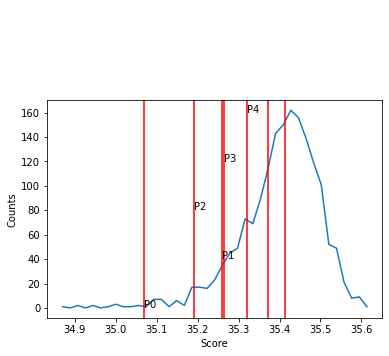

In [21]:
#Plots the Consistency score histogram and highlights points of interest
plt.plot(scoredata_lg.histogram_bins, scoredata_lg.histogram)
plt.xlabel('Score')
plt.ylabel('Counts')

for i in range( len(poi) ):
    x0 = poi[i][2]
    #gets the point score
    #This is one of the nice things about the routine that gets the points of interest
    #it returns a tuple with the locations, distance and score
    
    plt.axvline( x0, color='red')

    #Annotate lines
    #plt.annotate( 'P{}'.format(i), ( x0, fgaussian(x0, popt[0], popt[1], popt[2]) ) )
    plt.annotate( 'P{}'.format(i), ( x0, i*40 ) )
    #uses the gaussian approximation to get a rough location of the point

In [30]:
#In case leopardgecko.py has been modified, run these commands bellow
#import importlib
#importlib.reload(lg)

<module 'leopardgecko' from '/workspace/for_luis/Programming/Git_LeopardGecko/leopardgecko.py'>

# Manually segmented volumes - CS

In [23]:
if mySegmentedVolumes is not None:
  #Create a new histogram with the pre-segmented volume scores highlighted
  plt.plot(scoredata_lg.histogram_bins, scoredata_lg.histogram)
  plt.xlabel('Score')
  plt.ylabel('Counts')

  hmax = np.amax(scoredata_lg.histogram)

  for i in range( len(mySegmentedVolumes) ):
      #For each of the segmented volumes, calculates the Consistency Score
      g =mySegmentedVolumes[i]
      cscore_segm = predicteddata_lg.getWeightedValueAverageOfVolume( g )
      plt.axvline( cscore_segm , color='green')
      #plt.annotate("V{}".format(i) , (cscore_segm , (hmax / predicteddata_lg.vmax * cscore_segm) ) )
      plt.annotate("V{}".format(i) , (cscore_segm , i*40 ) )
      
      print ("V{} [ {}:{} , {}:{} , {}:{} ] , consistency score of {}". \
        format( i, g[0], g[1] , g[2],g[3] , g[4],g[5] ,  cscore_segm) )
  #plt.show()
else:
  print("No volumes selected.")

No volumes selected.


# Sørensen–Dice coefficient pooling

In [34]:
if dosccalculation is None:
    raise SystemExit("No Sorensen-Dice Coefficient calculation required, exiting. Stopping!")

In [36]:
import dask.array as da
import h5py
#Load the label data
fx= h5py.File(dosdccalculation,'r')
datasdclabels_da = da.from_array(fx['data'], chunks='auto')     

In [38]:
sdc_res = lg.SorensenDiceCoefficientCalculator3DPool( \
    predicteddata_lg.data_da , (predicteddata_lg.vmax + predicteddata_lg.vmin)/2 , \
    datasdclabels_da , 0.5 , \
    w_avg , k_width , s_stride )

In [39]:
sdc_res.origfilename = dosdccalculation

#Save data
_ , pathtail = os.path.split(data_filename)
pathname , ext = os.path.splitext(pathtail)
newpathname = pathname + "_SDC_k" + str(k_width)+"_s"+str(s_stride)
#newfilename = newpathname + '.h5' #Save file (locally, in the same folder as this notebook)
#pathfolder, _ = os.path.split(outputfilepdf)
sdc_filename = dataoutfolder + newpathname + '.h5'
print ("Sørensen–Dice coefficient filename: ", sdc_filename)

sdc_res.saveToFile(sdc_filename)
print("Saved Sorensen-Dice Coefficient 3D data to {}".format(sdc_filename))

Sørensen–Dice coefficient filename:  /workspace/for_luis/Programming/BenchmUsingGasHydrateData/2021-03-11_predicted_volumes/2021-03-12_final_12_volumes_combined_SDC_k256_s128.h5
Saved Sorensen-Dice Coefficient 3D data to /workspace/for_luis/Programming/BenchmUsingGasHydrateData/2021-03-11_predicted_volumes/2021-03-12_final_12_volumes_combined_SDC_k256_s128.h5


In [44]:
#sdc_res.data3d.shape

(14, 11, 11)

In [43]:
# Analyse SDC data
sdc_res.data3d.shape

(14, 11, 11)

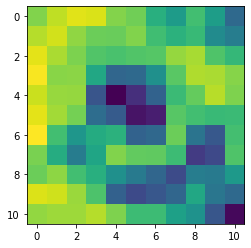

In [45]:
#plt.imshow(sdc_res.data3d[5,:,:])

Text(0, 0.5, 'Counts')

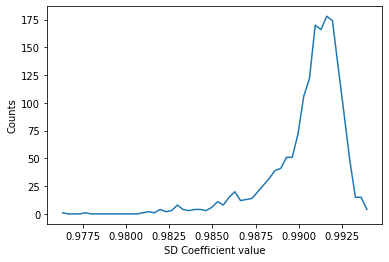

In [47]:
#SDC histogram
sdc_hist, sdc_bins = sdc_res.getHistogram()
plt.plot(sdc_bins,sdc_hist)
plt.xlabel('SD Coefficient value')
plt.ylabel('Counts')

## Sorensen-Dice coefficient  vs Consistency score

In [48]:
#Check shape of the arrays is consistent
print(sdc_res.data3d.shape)
print(scoredata_lg.data3d.shape)

(14, 11, 11)
(14, 11, 11)


In [56]:
print(type(sdc_res.data3d))
print(type(scoredata_lg.data3d))

<class 'numpy.ndarray'>
<class 'h5py._hl.dataset.Dataset'>


In [58]:
sdc_flat = sdc_res.data3d.flatten()

#Scoredata_lg can be a h5 data type so flatten operation ay not be available
cs_flat = np.copy(scoredata_lg.data3d).flatten()

Text(0, 0.5, 'Consistency Score value')

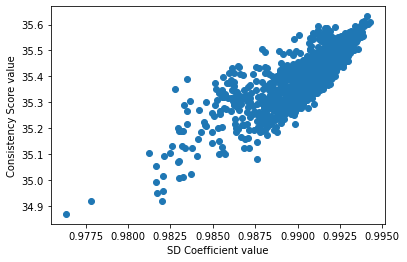

In [60]:
plt.scatter(sdc_flat,cs_flat)
plt.xlabel('SD Coefficient value')
plt.ylabel('Consistency Score value')
# Analyse SDC data, histogram + sdc vs cs scatter plots